# Final Project
**Luke Frymire**

**Question 6**


Begin by setting up environment and reading in data:

In [1]:
pip install pandas numpy matplotlib IPython

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from copy import deepcopy
from graph_tool.all import Graph, graph_draw, all_circuits, arf_layout
from IPython.core.debugger import set_trace
np.random.seed(1)

df_raw =  pd.read_csv("anonymized.csv")  # load main data
df_raw = df_raw.drop_duplicates()        # drop all duplicate rows in original raw data
with open("schools_data.json") as f:     # load school json file
    schools = json.loads(f.read())
f.close()

For this project, I consulted "School choice: a mechanism design approach" by Abdulkadiroglu and Soenmez (2003).

The goal of this problem is to compare the outcomes of matching algorithms under three scenarios. Under the first scenario, rankings will be completely randomized at the level of each individual student. This is equivalent to what is known as a "random serial dictatorship" mechanism. 

In the second scenario, each school will have its own specific ranking across all students. Under these conditions, the deferred acceptance algorithm is not Pareto-efficient, but dominates all other mechanisms which eliminate so-called "justified envy" - that is, a situation where a student prefers to attend another school, at which she is ranked higher than another current assignee. 

In the third scenario, I weaken the justified envy restriction such that a student with a higher ranking must only have a better opportunity to be accepted. This allows me to implement a Pareto-efficient mechanism called the top trading cycles mechanism. Using this algorithm, I can count the number of re-matchings from the second scenario that would allow students to attend more-preferred schools.

Finally, I provide code to run a monte carlo simulation to show how these results vary depending on the distribution of school rankings.

\
First, let's create the rankings:

In [3]:
df = df_raw.copy(deep=True)

def randomized_rank(data):
    """A function to generate a randomized ranking dictionary"""
    unique_ids = pd.unique(data['sIndex'])            # get IDs
    unique_ids = unique_ids[unique_ids != 'sIndex']   # drop col name from array
    obs = list(range(len(unique_ids)))                # create rankings for all students
    np.random.shuffle(obs)                            # randomize rankings
    rank_dict = {unique_ids[i]: obs[i] for i in range(len(unique_ids))}   # generate dictionary
    return(rank_dict)

def school_rank(data, schools_data):
    """A function to generate school-specific rankings"""
    n_schools = len(list(schools_data))          # get number of schools
    rankings = [{} for i in range(n_schools)]   # pre-allocate list of dictionaries
    for s in range(n_schools):
        rankings[s] = randomized_rank(data)     # generate a randomized ranking dictionary for each school
    return(rankings)

def gen_school_dicts(data, schools_data):
    n_schools = len(list(schools))
    school_dicts = school_rank(data, schools_data)
    for s in range(n_schools):
        data["s_" + str(s) + "_rank"] = data['sIndex'].map(school_dicts[s])   # match school specific rankings to each student
    return(data)

def gen_rankings(data, schools_data):
    rand_dict = randomized_rank(data)                 # call dictionary function
    df['rand_rank'] = data['sIndex'].map(rand_dict)   # map overall randomized ranking

    # create an index for each school name to make looping easier
    n_schools = len(list(schools_data))
    schoolIndex = {list(schools_data)[i]: range(n_schools)[i] for i in range(n_schools)}
    data['schoolIndex'] = data['ProgramName'].map(schoolIndex)
    
    # generate ranking columns
    data = gen_school_dicts(data, schools_data)
    return(data)
    
    
df = gen_rankings(df, schools)

In [4]:
df.head()

,Unnamed: 0,First Name,CHOICE,ProgramName,sIndex,open,matched,augmented,rand_rank,schoolIndex,...,s_8_rank,s_9_rank,s_10_rank,s_11_rank,s_12_rank,s_13_rank,s_14_rank,s_15_rank,s_16_rank,s_17_rank
0,1894.0,Grayson,1,Montessorri Alternate Program - Renfrew,277479538,True,False,1.668609664437562,375.0,7.0,...,582.0,544.0,884.0,900.0,110.0,756.0,806.0,304.0,601.0,813.0
1,1505.0,Jeved,1,Early Mandarin Bilingual - Norquay,277731278,True,False,0.7405798479018244,768.0,6.0,...,390.0,924.0,665.0,383.0,863.0,39.0,736.0,397.0,614.0,570.0
2,669.0,Jeved,3,Early French Immersion - Laura Secord,277731278,True,False,0.7405798479018244,768.0,8.0,...,390.0,924.0,665.0,383.0,863.0,39.0,736.0,397.0,614.0,570.0
3,1044.0,Jeved,2,Early French Immersion - Selkirk,277731278,True,False,0.7405798479018244,768.0,0.0,...,390.0,924.0,665.0,383.0,863.0,39.0,736.0,397.0,614.0,570.0
4,349.0,Phoenix,2,Early French Immersion - Jules Quesnel/Queen E...,277792112,True,False,0.6796190752791323,828.0,9.0,...,141.0,600.0,917.0,460.0,484.0,29.0,116.0,568.0,329.0,287.0


Next, lets run a deferred acceptance algorithm on the overall randomly assigned ranking.


In [5]:
def proposal(sIndex, ranking, ProgramName, data, schools_data, which_ranking):
    """A subroutine for the deferred acceptance algorithm.
    Represents an application from a student to a school of their choice.
    Returns True if the school is willing to accept the applicant, else False.
    ****
    First, check if the school has space. If so, append the student to the school's member list in
    "schools_data.json", change the "matched" column in the dataframe to True, and return True.
    If there is no space, check if the proposer's ranking is higher than the lowest-ranked student currently
    in their member list. If so, remove that student and replace them with the proposer, set "open" to False
    and "matched" to False for the student who was removed, set "matched" to True for the new applicant, and 
    return True.
    Else, set the "open" field to False for the new applicant and return False.
    """
    list = {}
    
    # confirm student not in program already
    if sIndex in schools[ProgramName]['members']:
        #print("Student already in program")
        #print("sIndex is:" + sIndex + "; ProgramName is: " + ProgramName)
        return False
    
    # check if there is room
    # if so, add student to member list, and set "matched" to True for the row in df
    # in which the applicant has ranked the program they are applying to. Return True.
    if len(schools_data[ProgramName]['members']) < schools_data[ProgramName]['seats']:
        schools_data[ProgramName]['members'].append(sIndex)
        data.loc[(data['ProgramName'] == ProgramName) & (data['sIndex'] == sIndex), ['matched']] = "True"
        return True
    
    # if no room, we need to check for the current member with the lowest ranking
    # create a list of current members with their rankings:
    for each in schools_data[ProgramName]['members'] :
        f = data.loc[(data['ProgramName'] == ProgramName)&(data['sIndex'] == each)]
        list[each] =f.iloc[0][which_ranking] 
        del f
        
    # get the minimum value in the new list
    v = min(list,key=list.get)
    
    # if the applicant's ranking is lower than the worst currently accepted student,
    # set "open" to False for them to reject them permanently.
    if ranking <= list[v]:
        #reject
        data.loc[(data['ProgramName'] == ProgramName)&(data['sIndex'] == sIndex),['open']]="False"
        return False
    
    # if the applicant's ranking is higher than the current lowest, remove the worst student
    # and replace them with the new applicant.
    data.loc[(data['ProgramName'] == ProgramName)&(data['sIndex'] == v),['open']]="False"
    data.loc[(data['ProgramName'] == ProgramName)&(data['sIndex'] == v),['matched']]="False"
    schools_data[ProgramName]['members'].remove(v)
    schools_data[ProgramName]['members'].append(sIndex)
    data.loc[(data['ProgramName'] == ProgramName)&(data['sIndex'] == sIndex),['matched']]="True"
    return True


Now let's run the deferred acceptance algorithm. We will iterate three times, since students can select up to three schools to rank.

In [6]:
def DA_algo(data, schools, iterations):
    """Deferred acceptance algorithm.
    data: dataframe with students choices and school rankings
    schools: empty JSON style dictionary object for schools data
    iterations: number of times to run the algorithm
    Returns a dataframe populated with school matchings and the populated JSON file.
    """
    for i in range(iterations):
        # current keeps track of which student we're on.
        current = 0
        for index,element in data.iterrows():
            # if the student is unmatched, hasn't already proposed this round,
            # and is allowed to propose at the current school, propose
            if (element['matched'] == "False") and (current != element['sIndex']) and (element['open'] == "True"):
                test = proposal(element['sIndex'], element['rand_rank'], element['ProgramName'], data, schools, 'rand_rank')
                current = element['sIndex']
            # if already matched, do not propose but update current so that we can skip rows where 
            # they would apply to other schools this round
            elif element['matched'] == "True":
                current = element['sIndex']
            # otherwise (e.g. is unmatched but has already applied this round), skip altogether
            else:
                continue
    return([data, schools])

# run the algorithm
df_1 = df.copy(deep=True)
df_1 = DA_algo(df_1, schools, 3)[0]

Let's have a look at what we've got:

In [7]:
df_1_accepted = df_1[df_1['matched']=="True"]
df_1_accepted

,Unnamed: 0,First Name,CHOICE,ProgramName,sIndex,open,matched,augmented,rand_rank,schoolIndex,...,s_8_rank,s_9_rank,s_10_rank,s_11_rank,s_12_rank,s_13_rank,s_14_rank,s_15_rank,s_16_rank,s_17_rank
1,1505.0,Jeved,1,Early Mandarin Bilingual - Norquay,277731278,True,True,0.7405798479018244,768.0,6.0,...,390.0,924.0,665.0,383.0,863.0,39.0,736.0,397.0,614.0,570.0
4,349.0,Phoenix,2,Early French Immersion - Jules Quesnel/Queen E...,277792112,True,True,0.6796190752791323,828.0,9.0,...,141.0,600.0,917.0,460.0,484.0,29.0,116.0,568.0,329.0,287.0
8,679.0,Enrelle,3,Early French Immersion - Laura Secord,278548324,True,True,0.7123621283162467,690.0,8.0,...,919.0,841.0,167.0,380.0,211.0,428.0,198.0,139.0,137.0,311.0
11,554.0,Selina,1,Early French Immersion - Laura Secord,278548340,True,True,0.5754198469255692,917.0,8.0,...,721.0,430.0,506.0,191.0,649.0,603.0,222.0,308.0,269.0,391.0
14,1006.0,Vallen,1,Early French Immersion - Selkirk,278548756,True,True,0.4140587994151095,810.0,0.0,...,198.0,175.0,60.0,875.0,82.0,53.0,176.0,548.0,67.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,1880.0,Eliza,1,Montessorri Alternate Program - Renfrew,293727466,True,True,1.1625792683876925,645.0,7.0,...,316.0,639.0,661.0,264.0,131.0,402.0,309.0,372.0,906.0,915.0
2098,36.0,Hailey,1,Early French Immersion - Douglas Annex,293735848,True,True,0.4352072881845386,715.0,17.0,...,488.0,299.0,465.0,857.0,849.0,204.0,378.0,861.0,6.0,373.0
2101,680.0,Maxwell,3,Early French Immersion - Laura Secord,293747282,True,True,0.05099169808973625,905.0,8.0,...,398.0,529.0,284.0,637.0,589.0,495.0,145.0,652.0,529.0,476.0
2104,218.0,Syra,2,Early French Immersion - Hudson,293747480,True,True,0.39633969667233493,767.0,15.0,...,581.0,401.0,379.0,466.0,170.0,95.0,741.0,61.0,302.0,367.0


There should be 600 seats available, but we only have 584 accepted in our dataframe.

In [8]:
tot = 0
for s in list(schools):
    tot = tot + schools[s]['seats']
    if len(schools[s]['members']) < schools[s]['seats']:
        print(s + " is not full")
        print("Total number of seats:")
        print(schools[s]['seats'])
        print("Current members:")
        print(schools[s]['members'])
        print("Total number of students who ranked this program:")
        print(len(df_1[df_1['ProgramName']==s]))
        print("")


Indigenous Focus - Xpey' is not full
Total number of seats:
20
Current members:
['293444192', '293446008', '293449970']
Total number of students who ranked this program:
5



It appears one program did not fully fill up; presumably the remaining students who ranked this programs in their top three were accepted to a prefered school instead.

Save our json file so that we can use a fresh slate for the second part of the exercise:

In [9]:
# save results from first exercise
out_file = open("schools_data_1.json","w")
json.dump(schools, out_file, indent=6)
out_file.close()

# set "schools" to empty json file
with open("schools_data.json") as f: 
    schools = json.loads(f.read())
f.close()

Next, we can run the deferred acceptance algorithm again, now allowing each school to have a private ranking of students.

In [10]:
def DA_algo_individual(data, schools, iterations):
    """Deferred acceptance algorithm which allows each school to have an independent ranking over students.
    data: dataframe with students choices and school rankings
    schools: empty JSON style dictionary object for schools data
    iterations: number of times to run the algorithm
    Returns a dataframe populated with school matchings and the populated JSON data.
    """
    for i in range(iterations):
        current = 0
        for index,element in data.iterrows():
            if (element['matched'] == "False") and (current != element['sIndex']) and (element['open'] == "True"):
                school_rank = ("s_" + str(int(element['schoolIndex'])) + "_rank")
                test = proposal(element['sIndex'], element[school_rank], element['ProgramName'], data, schools, school_rank)
                current = element['sIndex']
            elif element['matched'] == "True":
                current = element['sIndex']
            else:
                continue
    return([data, schools])

df_2 = df.copy(deep=True)
df_2 = DA_algo_individual(df_2, schools, 3)[0]

In [11]:
df_2_accepted = df_2[df_2['matched']=="True"]
df_2_accepted

,Unnamed: 0,First Name,CHOICE,ProgramName,sIndex,open,matched,augmented,rand_rank,schoolIndex,...,s_8_rank,s_9_rank,s_10_rank,s_11_rank,s_12_rank,s_13_rank,s_14_rank,s_15_rank,s_16_rank,s_17_rank
3,1044.0,Jeved,2,Early French Immersion - Selkirk,277731278,True,True,0.7405798479018244,768.0,0.0,...,390.0,924.0,665.0,383.0,863.0,39.0,736.0,397.0,614.0,570.0
4,349.0,Phoenix,2,Early French Immersion - Jules Quesnel/Queen E...,277792112,True,True,0.6796190752791323,828.0,9.0,...,141.0,600.0,917.0,460.0,484.0,29.0,116.0,568.0,329.0,287.0
7,1691.0,Rui En,1,Fine Arts - Nootka,278494764,True,True,1.4794371581465733,255.0,3.0,...,155.0,186.0,536.0,35.0,679.0,602.0,239.0,177.0,915.0,574.0
8,679.0,Enrelle,3,Early French Immersion - Laura Secord,278548324,True,True,0.7123621283162467,690.0,8.0,...,919.0,841.0,167.0,380.0,211.0,428.0,198.0,139.0,137.0,311.0
11,554.0,Selina,1,Early French Immersion - Laura Secord,278548340,True,True,0.5754198469255692,917.0,8.0,...,721.0,430.0,506.0,191.0,649.0,603.0,222.0,308.0,269.0,391.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2094,466.0,Gwendolyn,1,Early French Immersion - Kerrisdale,293715866,True,True,1.16774454324759,847.0,10.0,...,471.0,772.0,549.0,849.0,775.0,848.0,551.0,209.0,116.0,430.0
2098,36.0,Hailey,1,Early French Immersion - Douglas Annex,293735848,True,True,0.4352072881845386,715.0,17.0,...,488.0,299.0,465.0,857.0,849.0,204.0,378.0,861.0,6.0,373.0
2105,38.0,Syra,1,Early French Immersion - Douglas Annex,293747480,True,True,0.39633969667233493,767.0,17.0,...,581.0,401.0,379.0,466.0,170.0,95.0,741.0,61.0,302.0,367.0
2109,2018.0,Marcus,1,Montessorri Alternate Program - Tyee,293767842,True,True,0.22477254583077877,72.0,14.0,...,274.0,189.0,362.0,572.0,70.0,243.0,835.0,29.0,823.0,924.0


Again, lets check which programs didn't fill up completely:

In [12]:
tot = 0
for s in list(schools):
    tot = tot + schools[s]['seats']
    if len(schools[s]['members']) < schools[s]['seats']:
        print(s + " is not full")
        print("Total number of seats:")
        print(schools[s]['seats'])
        print("Current members:")
        print(schools[s]['members'])
        print("Total number of students who ranked this program:")
        print(len(df_2[df_2['ProgramName']==s]))


Indigenous Focus - Xpey' is not full
Total number of seats:
20
Current members:
['293444192', '293446008', '293449970']
Total number of students who ranked this program:
5


In [13]:
# save the results from the second exercize
out_file = open("schools_data_2.json","w")
json.dump(schools, out_file, indent=6)
out_file.close()

\
In the next section, I will implement a top trading cycles algorithm and count the number of students who would have been able to reach a better match in the second exercise. For this section, I read and adapted some code from Iacopo Garizio at https://github.com/igarizio/py-school-match/blob/master/py_school_match/algorithms/ttc.py, particularly to figure out the graph aspect.

The algorithm can be outlined as follows:
1. Each student points to their most prefered school; each school points to their highest ranked student. There will be at least one cycle, which is a situation where a series of students and schools are pointing at each other in series, with the final agent pointing at the initial one such that they form a loop. Assign every student who is in a cycle to the school to which they point, and remove them from the pool of candidates.
2. Repeat Step 1. After each repetition, remove any schools with no remaining seats. Terminate the algorithm when either all students have been assigned, or all seats have been filled.


First we need to create some subroutines for the algorithm. 

*point_student* iterates through the dataframe to have all students still awaiting assignment point at their most preferred school.

*point_school* iterates through the database to have each school which is not yet full point to their highest ranked student which is still available.

In [14]:
def point_student(data, remaining_students, remaining_schools):
    is_pointing_student = []
    for index,element in data.iterrows():
        
        # confirm student and school are both still under consideration
        if (element['sIndex'] in remaining_students) & (element['ProgramName'] in remaining_schools):
            
            # if student is already pointing, check if this is prefered school
            if element['sIndex'] in is_pointing_student:
                
                # if current row is for a school prefered to current pointer,
                # AND school is still open to new applicants,
                # remove old pointer and point to this school
                if int(element['CHOICE']) < int(data.loc[(data['sIndex'] == element['sIndex']) & (data['pointing_student']), ['CHOICE']].iloc[0][0]):
                    data.loc[data['sIndex'] == element['sIndex'], ['pointing_student']] = False
                    data.loc[(data['sIndex'] == element['sIndex']) & (data['ProgramName'] == element['ProgramName']), ['pointing_student']] = True
                    continue
                    
                else:
                    continue
            
            # since student is not yet pointing, add pointer if school is available
            else:
                data.loc[(data['sIndex'] == element['sIndex']) & (data['ProgramName'] == element['ProgramName']), ['pointing_student']] = True
                is_pointing_student.append(element['sIndex'])
                continue
                
        # if school being applied to is full, check if all of the schools the student is applying to are full
        if (element['sIndex'] in remaining_students) & (element['ProgramName'] not in remaining_schools):
            all_applications = data.loc[data['sIndex'] == element['sIndex'], ['ProgramName']]
            
            # if all schools the student wants to apply to are full, remove student from the algorithm
            if not any(all_applications.ProgramName.isin(remaining_schools)):
                remaining_students = np.delete(remaining_students, np.where(remaining_students == element['sIndex']))
            else:
                continue
            
        else:
            continue
    return(remaining_students)
            

def point_school(data, schools_data, remaining_students, remaining_schools):
    is_pointing_school = []
    for index,element in data.iterrows():
        
        # confirm school has space and student is still looking to apply
        if (element['ProgramName'] in remaining_schools) & (element['sIndex'] in remaining_students):
            
            # denotes which ranking column to use
            school_rank = ("s_" + str(int(element['schoolIndex'])) + "_rank")

            # if school is already pointing, check to see if current student has a better ranking
            if element['ProgramName'] in is_pointing_school:
                
                # if ranking is higher, remove old pointer and point to this student
                if element[school_rank] > int(data.loc[(data['schoolIndex'] == element['schoolIndex']) & (data['pointing_school']), [school_rank]].iloc[0][0]):
                    
                    data.loc[data['ProgramName'] == element['ProgramName'], ['pointing_school']] = False
                    data.loc[(data['sIndex'] == element['sIndex']) & (data['ProgramName'] == element['ProgramName']), ['pointing_school']] = True
                    continue
                    
                else:
                    continue

            # since school is not yet pointing, add pointer
            else:
                data.loc[(data['sIndex'] == element['sIndex']) & (data['ProgramName'] == element['ProgramName']), ['pointing_school']] = True
                is_pointing_school.append(element['ProgramName'])
                continue
                
        else:
            continue
            
                

The next step is to write a subroutine to identify pointing cycles. I use a package called "graph-tool" to generate a graph of all of the pointing connections between students and schools and to analyze the graph for cycles.

In [15]:
class GraphAttr:
    """Class object to hold graph and corresponding list of attributes for vertices and their IDs"""
    
    def _init_(self):
        self.graph = Graph(directed=True)
        self.vertex_ids = pd.DataFrame(columns = ['v','ID','type'])

        
        
def populate_vertices(data, ga, remaining_students, remaining_schools): 
    """Takes an empty GraphAttr object, populates the graph, 
    and builds a dictionary linking each vertex with ID and type properties"""
    
    # add student vertices and assign properties
    for student in remaining_students:
        v = ga.graph.add_vertex()
        new_row = pd.DataFrame([[v,student,"student"]],columns=['v','ID','type'])
        ga.vertex_ids = ga.vertex_ids.append(new_row)
        del(v,new_row)
    
    # add school vertices and assign properties
    for school in remaining_schools:
        v = ga.graph.add_vertex()
        new_row = pd.DataFrame([[v,school,"school"]],columns=['v','ID','type'])
        ga.vertex_ids = ga.vertex_ids.append(new_row)
        del(v,new_row)

    return(ga)
    
    
def populate_edges(data, ga, remaining_students, remaining_schools):
    """Takes a populated GraphAttr object with vertices and populates with directed edges representing pointers"""   
    
    for v in ga.graph.vertices(): 
        # create edges from students to schools
        v_type = ga.vertex_ids[ga.vertex_ids['v']==v]['type']
        if v_type[0] == 'student':
            student_id = ga.vertex_ids[ga.vertex_ids['v']==v]['ID'][0]
            student_vertex = v
            if student_id in remaining_students:
                school_id = data.loc[(data['sIndex'] == student_id) & (data['pointing_student'] == True), ['ProgramName']].iloc[0][0]
                school_vertex = ga.vertex_ids[ga.vertex_ids['ID']==school_id]['v'][0]
                if school_id in remaining_schools:
                    ga.graph.add_edge(student_vertex, school_vertex)
            
        # create edges from schools to students
        if v_type[0] == 'school':
            school_id = ga.vertex_ids[ga.vertex_ids['v']==v]['ID'][0]
            school_vertex = v
            if school_id in remaining_schools:
                # skip if nobody currently pointing at school:
                if len(data.loc[(data['ProgramName'] == school_id) & (data['pointing_school'] == True)]) != 0:
                    student_id = data.loc[(data['ProgramName'] == school_id) & (data['pointing_school'] == True), ['sIndex']].iloc[0][0]
                    student_vertex = ga.vertex_ids[ga.vertex_ids['ID']==student_id]['v'][0]
                    if student_id in remaining_students:
                        ga.graph.add_edge(school_vertex, student_vertex)
        
    return(ga)



def find_cycles(graph):
    """Takes a populated graph and returns an iterated list of the cycles contained within""" 
    cycles = [c for c in all_circuits(graph, unique=True)]
    
    return(cycles)

Finally, lets write the main algorithm:

In [16]:
def TTC_algo(data, schools):
    """Top trading cycles algorithm implementation. 
    data: dataframe with students choices and school rankings
    schools: empty JSON style dictionary object for schools data
    Returns a populated JSON style dictionary object with all matchings"""
    
    # initialize list of remaining students and schools
    all_schools = list(schools)
    remaining_students = pd.unique(df_3['sIndex']) 
    remaining_schools = all_schools
    
    iteration_counter = 1
    
    # run until we run out of either unmatched students or schools with free seats
    while not ((len(remaining_students) == 0) | (len(remaining_schools) == 0)) | (remaining_schools=='E'):   
        
        # remove any existing pointers
        data['pointing_student'] = False
        data['pointing_school'] = False
        
        # have students and schools point to their prefered choice
        # note that point_students will remove students if they have no open choices left
        remaining_students = point_student(data, remaining_students, remaining_schools)
        point_school(data, schools, remaining_students, remaining_schools)
        
        # create GraphAttr object, populate it, and identify cycles
        ga = GraphAttr()
        ga._init_()
        ga = populate_vertices(data, ga, remaining_students, remaining_schools)
        ga = populate_edges(data, ga, remaining_students, remaining_schools)
        cycles = find_cycles(ga.graph)
        
        # if there are still remaining cycles, continue
        if len(cycles) > 0:
            for cycle in cycles:
    
                #iterate over each vertex in cycle
                for index, obj in enumerate(cycle):
                    current_vertex = cycle[index]
                    if index < len(cycle)-1:
                        next_vertex = cycle[index + 1]
                    if index == len(cycle)-1:
                        next_vertex = cycle[0]
    
                    v_id = ga.vertex_ids[ga.vertex_ids['v']==current_vertex]['ID'][0]
                    v_id_next = ga.vertex_ids[ga.vertex_ids['v']==next_vertex]['ID'][0]
                    
                    # if current vertex represents a student...
                    if v_id in remaining_students:
                        # sanity check to make sure next vertex in cycle is a school
                        if v_id_next not in all_schools:
                            print("cycle has a student pointing at another student?")
                        
                        # ... add them to the member list of the school they point to...
                        schools[v_id_next]['members'].append(v_id)
                        # ... and remove them from the list of remaining students.
                        remaining_students = np.delete(remaining_students, np.where(remaining_students == v_id))
                        
                for school in remaining_schools:
                    
                    # sanity check to ensure we haven't overfilled anything
                    if len(schools[school]['members']) > schools[school]['seats']:
                        print(school +" is too full!")
                    
                    # remove full schools
                    if len(schools[school]['members']) == schools[school]['seats']:
                        remaining_schools = [x for x in remaining_schools if x != school]
                            
        iteration_counter += 1
        
    return(schools)

Run the algorithm:

In [17]:
df_3 = df.copy(deep=True)
df_3 = df_3[:-1]
df_3['pointing_student'] = False    # create column to denote if student is pointing at school
df_3['pointing_school'] = False     # create column to denote if school is pointing at student

with open("schools_data.json") as f:   # refresh school json file
    schools = json.loads(f.read())
f.close()

schools_out = TTC_algo(df_3, schools)

In [18]:
# save results from TTC algorithm
out_file = open("schools_data_3.json","w")
json.dump(schools_out, out_file, indent=6)
out_file.close()

Now that we've run the top cycle trading algorithm, we need to count the number or rematchings which allowed students to go to a school they prefer.

In [19]:
def get_changes(data, sIndex, school_new, school_old):
    """takes an sIndex ID and two schools, returns the amount by which they improved.
    -999: the student was previously matched but no longer has a match
    -2: the student's match worsened by two rankings
    -1: the student's match worsened by one ranking
    0: the student did not improve
    1: the student improved by one ranking
    2: the student improved by two rankings
    999: the student was not previously matched but now is
    """
    
    if (school_new != "None") & (school_old != "None"):
        old_rank = int(data.loc[(data['sIndex'] == sIndex) & (data['ProgramName'] == school_old)].reset_index(drop=True).CHOICE[0])
        new_rank = int(data.loc[(data['sIndex'] == sIndex) & (data['ProgramName'] == school_new)].reset_index(drop=True).CHOICE[0])
        return(str(old_rank - new_rank))
    
    if (school_new == "None") & (school_old != "None"):
        return('-999')
    
    if (school_new != "None") & (school_old == "None"):
        return('999')
    
    if (school_new == "None") & (school_old == "None"):
        return('0')
    
    
def get_matches(sIndex, schools_new, schools_old):
    """Takes an sIndex ID and two lists of matchings.
    Returns a list containing the new school and the old school that student was matched to.
    If a student is not matched, the list element for that matching will be set to "None"
    """
    
    new_match = "None"
    old_match = "None"
    
    for school in list(schools_new):
        if sIndex in schools_new[school]['members']:
            new_match = school
    
    for school in list(schools_old):
        if sIndex in schools_old[school]['members']:
            old_match = school
            
    return([new_match, old_match])

def count_improvements(data, schools_new, schools_old):
    """Function to run the count of improvements in a new set of matchings vis-a-vis the old matchings
    Returns a dictionary containing the number of each type of improvement (see comments on check_if_improved)
    """
    
    count_dict = {'-999':[0], '-2':[0], '-1':[0], '0':[0], '1':[0], '2':[0], '999':[0]}
    unique_ids = pd.unique(data['sIndex'])
    unique_ids = unique_ids[unique_ids != 'sIndex']
    
    for i in unique_ids:
        matches = get_matches(i, schools_new, schools_old)
        change = get_changes(data, i, matches[0], matches[1])
        count_dict[change][0] += 1
    
    return(count_dict)

In [20]:
with open("schools_data_3.json") as f:
    schools_new = json.loads(f.read())
f.close()
with open("schools_data_2.json") as f:
    schools_old = json.loads(f.read())
f.close()

improvements = count_improvements(df, schools_new, schools_old)
improvements

{'-999': [49],
 '-2': [0],
 '-1': [4],
 '0': [615],
 '1': [125],
 '2': [91],
 '999': [49]}

The above dictionary tells us that the top trading cycles algorithm significantly improved upon the deferred acceptance algorithm when schools have individual rankings. We were able to bump up 125 students to a school which they ranked one spot higher, and 91 students to a school which they ranked two spots higher than their initial match. 

We did have 4 students who ended up in a school which they'd ranked one spot lower, and 49 students who initially had a match but no longer do. The latter is exactly offset by the 49 students who previously did not have a match and now do.

Finally, we *could* repeat this experiment with different initial rankings to get an idea of the distribution of performance improvements. Unfortunately, this is a very time intensive process, as each cycle of running the algorithms takes about 15 minutes on my computer. I also tried running the program using Google Colaboratory to see if their CPUs were faster, but the timing took even longer. I wasn't willing to pay for their premium CPUs. 

Consequently, I'll just present the code that would be used to loop through the algorithms and create a histogram of the mean weighted change in rankings:

In [21]:
def loop_algos(df_raw,loops):
    # container for results
    results = []
    
    for i in range(loops):
        np.random.seed(i)
        
        #count
        print(i)
        
        # initialize data for the algorithms with new rankings
        df = gen_rankings(df_raw, schools)
        df_DA = df.copy(deep=True)[:-1]
        df_TTC = df.copy(deep=True)[:-1]
        
        #initialize two schools objects
        with open("schools_data.json") as f: 
            schools_raw = json.loads(f.read())
        f.close()
        schools_DA = deepcopy(schools_raw)
        schools_TTC = deepcopy(schools_raw)
        
        #run DA algorithm
        schools_out_DA = DA_algo_individual(df_DA, schools_DA, 3)[1]
        #run TTC algorithm
        schools_out_TTC = TTC_algo(df_TTC, schools_TTC)
        
        #compare
        results.append(count_improvements(df_TTC, schools_out_TTC, schools_out_DA))
        
    return(results)
    

def mean_improvement(results):
    n = len(results)
    means = []
    for i in range(n):
        two_down = results[i]['-1'][0]
        one_down = results[i]['-1'][0]
        one_up = results[i]['1'][0]
        two_up = results[i]['2'][0]
        weighted_mean = (-2*two_down) + (-1*one_down) + (1*one_up) + (2*two_up)
        means.append(weighted_mean)
    return(means)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0.5, 1.0, 'Mean weighted improvement')

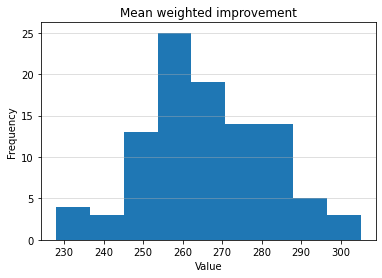

In [22]:
# """
results = loop_algos(df_raw,100)
means = mean_improvement(results)

# plot as histogram
n, bins, patches = plt.hist(x=means, bins='auto')
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Mean weighted improvement') 
# """